In [1]:
import os
import sys
import pandas as pd
sys.path.insert(0, "../../")
from src.text.epu import EPU
from src.tourism.ts_utils import *

from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.vector_ar.vecm import select_order, select_coint_rank

In [2]:
target_folder = sys.path[0] + "/data/text/samoa/"
output_folder = sys.path[0] + "/outputs/text/samoa/"
target_files = [target_folder + file for file in os.listdir(target_folder) 
                if "news" in file and "ner" not in file]
ner_files = [target_folder + file for file in os.listdir(target_folder) 
             if "ner" in file]

In [3]:
urls_to_exclude = []
for file in ner_files:
    df = pd.read_csv(file)
    df["ner"] = df["ner"].str.lower()
    urls = [
        url for ner, url in zip(df["ner"], df["url"])
        if "risk" in str(ner) or "uncertain" in str(ner)
    ]
    urls_to_exclude.extend(urls)

In [4]:
e = EPU(target_files, cutoff='2020-12-31', non_epu_urls=urls_to_exclude)
e.get_epu_category(subset_condition="date >= '2016-01-01' and date < '2024-01-01'")
e.get_count_stats()
e.calculate_epu_score()

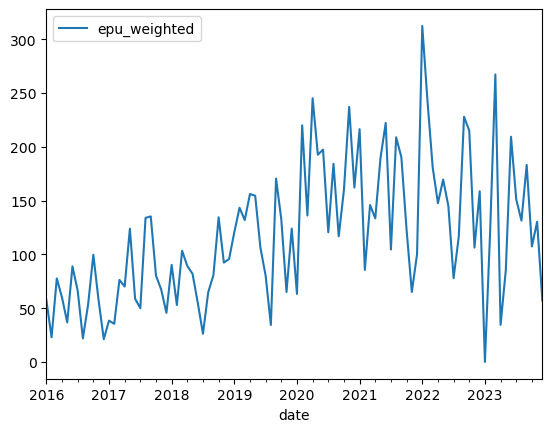

In [5]:
samoa_stats = e.epu_stats
samoa_stats.plot(x="date", y="epu_weighted");

In [6]:
#17m1-23m12
cpi_list = [
    104.4, 100.0, 99.6, 99.5, 100.2, 101.6, 103.4, 101.7, 101.3, 100.5, 100.2,
    101.0, 101.5, 101.6, 101.0, 100.7, 101.7, 102.6, 103.4, 104.3, 103.6,
    104.3, 105.0, 103.6, 110.3, 110.0, 108.8, 108.4, 111.6, 115.5, 115.6,
    114.7, 113.9, 113.8, 111.7, 108.6, 102.0, 104.8, 106.5, 106.1, 106.4,
    106.7, 108.4, 109.1, 109.4, 109.3, 109.0, 108.4, 109.7, 110.5, 111.0,
    107.9, 105.8, 104.9, 106.3, 107.0, 105.6, 103.6, 103.2, 103.4, 103.7,
    105.6, 107.1, 107.1, 107.7, 109.2, 111.0, 112.7, 112.8, 113.6, 113.0,
    115.3, 114.8, 115.3, 116.2, 117.2, 117.3, 121.0, 125.3, 129.9, 130.1,
    127.7, 124.6, 124.0, 128.2, 129.0, 129.8, 131.8, 131.5, 133.9, 134.0,
    132.8, 131.8, 132.3, 132.4, 132.0
]

In [7]:
cpi_df = pd.DataFrame(pd.date_range(start="2016-01-01",
                                    end="2023-12-01",
                                    freq="MS"),
                      columns=["date"])
cpi_df["cpi"] = cpi_list
cpi_df["inflation"] = cpi_df["cpi"].diff() * 100/ cpi_df["cpi"].shift(1)
cpi_df = cpi_df.merge(samoa_stats[["date", "epu_weighted", "epu_unweighted"]], how="left", on="date")
# cpi_df["epu_ma3"] = cpi_df["epu_weighted"].rolling(3).mean()
cpi_df["epu_diff"] = cpi_df["epu_weighted"].diff()
cpi_df.head(5)

,date,cpi,inflation,epu_weighted,epu_unweighted,epu_diff
0,2016-01-01,104.4,NaN,57.685219,47.811039,NaN
1,2016-02-01,100.0,-4.214559,22.892622,18.123204,-34.792597
2,2016-03-01,99.6,-0.400000,77.623597,61.698622,54.730975
3,2016-04-01,99.5,-0.100402,59.875797,47.644450,-17.747800
4,2016-05-01,100.2,0.703518,36.775028,28.985601,-23.100769


In [8]:
model_df = cpi_df.dropna()
get_adf_df(model_df, ["cpi", "inflation", "epu_weighted", "epu_unweighted","epu_diff"])

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value 1%,Critical Value 5%,Critical Value 10%
cpi,-0.578602,8.757442e-01,1.0,93.0,-3.502705,-2.893158,-2.583637
inflation,-8.051926,1.732780e-12,0.0,94.0,-3.501912,-2.892815,-2.583454
epu_weighted,-6.444011,1.582300e-08,0.0,94.0,-3.501912,-2.892815,-2.583454
epu_unweighted,-8.551447,9.199743e-14,0.0,94.0,-3.501912,-2.892815,-2.583454
epu_diff,-6.086833,1.059432e-07,7.0,87.0,-3.507853,-2.895382,-2.584824


In [9]:
import statsmodels.formula.api as smf
res = smf.ols("inflation~epu_unweighted",data=model_df)
res.fit(cov_type="HAC", cov_kwds={"maxlags":4}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              inflation   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                     1.273
Date:                Fri, 22 Mar 2024   Prob (F-statistic):              0.262
Time:                        01:12:45   Log-Likelihood:                -182.69
No. Observations:                  95   AIC:                             369.4
Df Residuals:                      93   BIC:                             374.5
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.4185      0.225      1.860      0.063      -0.023       0.859
epu_unweighted    -0.0012      0.001     -1.128      0.259      -0.003       0.001
==============================================================================
Omnibus:                       12.380   Durbin-Watson:                   1.488
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               39.324
Skew:                          -0.067   Prob(JB):                     2.89e-09
Kurtosis:                       6.149   Cond. No.                         255.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 4 lags and without small sample correction
"""

In [14]:
from statsmodels.tsa.api import VAR, ARDL

model = VAR(model_df[["epu_weighted", "inflation"]])
res = model.fit(ic="aic", trend='ct')
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 22, Mar, 2024
Time:                     01:13:49
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    9.23223
Nobs:                     94.0000    HQIC:                   9.10321
Log likelihood:          -682.502    FPE:                    8232.81
AIC:                      9.01578    Det(Omega_mle):         7574.46
--------------------------------------------------------------------
Results for equation epu_weighted
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  54.799731        13.256861            4.134           0.000
trend                   0.974451         0.254103            3.835           0.000
L1.epu_weighted         0.157041         0.10

In [16]:
res.test_causality("inflation", "epu_weighted").summary()

Test statistic,Critical value,p-value,df
0.1640,3.894,0.686,"(1, 180)"


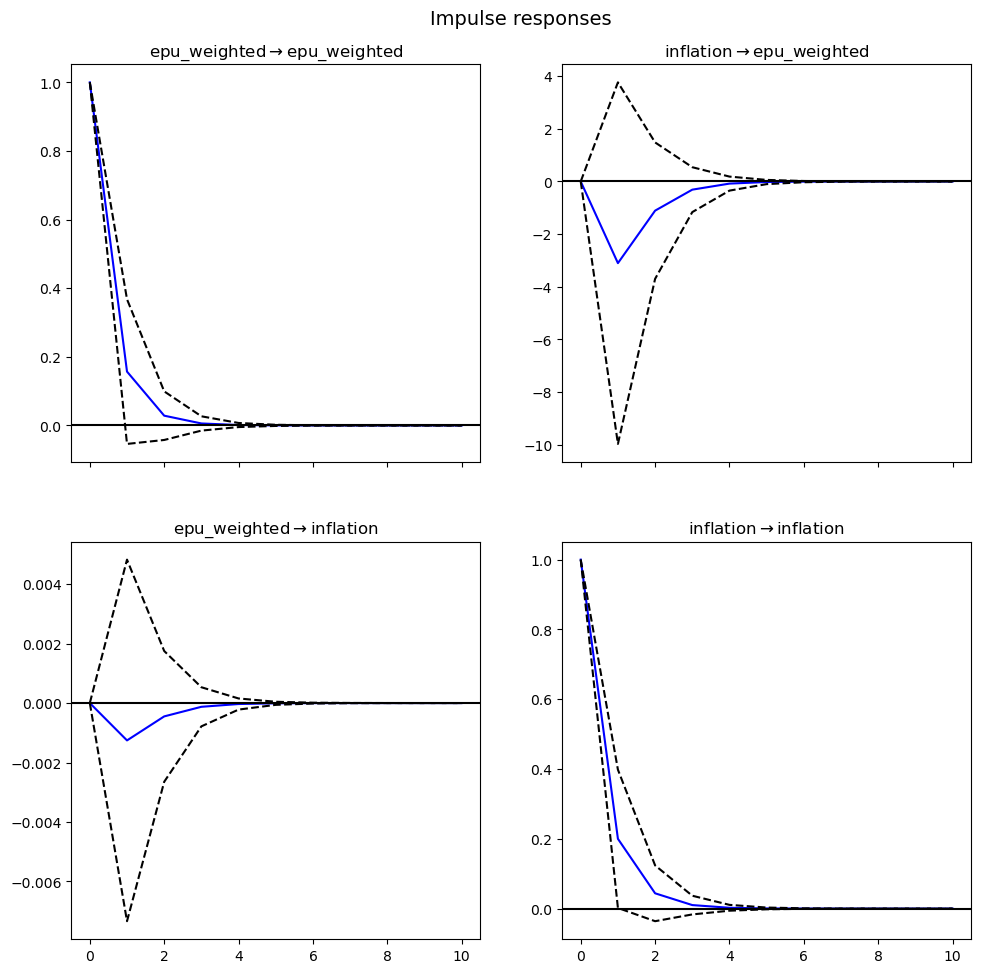

In [17]:
res.irf().plot();

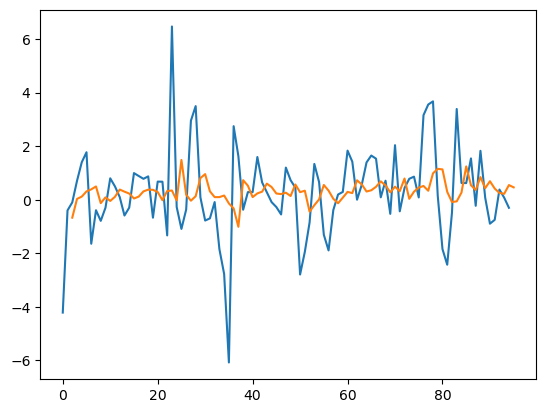

In [18]:
import matplotlib.pyplot as plt


plt.plot(model_df.inflation.values)
plt.plot(res.fittedvalues["inflation"]);

In [19]:
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order

ardl_order = ardl_select_order(endog=model_df[['inflation']],
                               exog=model_df[['epu_weighted']],
                               maxlag=12,
                               maxorder=12)
ardl_res = ardl_order.model.fit()
ardl_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:              inflation   No. Observations:                   95
Model:                       ARDL(0,)   Log Likelihood                -183.033
Method:               Conditional MLE   S.D. of innovations              1.662
Date:                Fri, 22 Mar 2024   AIC                            370.066
Time:                        01:14:16   BIC                            375.174
Sample:                             0   HQIC                           372.130
                                   95                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2610      0.171      1.523      0.131      -0.079       0.601
==============================================================================
"""

In [20]:
max_lag = 10  # Set the maximum lag order to consider
res = select_order(model_df[["epu_weighted", "cpi"]].iloc[1:],
                   maxlags=max_lag,
                   deterministic='ci',
                   seasons=4)
optimal_order = res.selected_orders
rank_test = select_coint_rank(model_df[["epu_weighted", "cpi"]].iloc[1:],
                              1,
                              optimal_order["aic"],
                              method="trace",
                              signif=0.05)

# Fit VECM model with the determined order
model = VECM(model_df[["epu_weighted", "cpi"]].iloc[1:],
             k_ar_diff=optimal_order["aic"],
             coint_rank=rank_test.rank)
fitted_model = model.fit()

# Print the summary of the fitted model
print(fitted_model.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation epu_weighted
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
L1.epu_weighted    -0.2483      0.123     -2.013      0.044      -0.490      -0.007
L1.cpi             -2.1159      3.346     -0.632      0.527      -8.674       4.442
L2.epu_weighted    -0.1800      0.102     -1.771      0.077      -0.379       0.019
L2.cpi              5.1322      3.351      1.531      0.126      -1.436      11.701
 Det. terms outside the coint. relation & lagged endog. parameters for equation cpi
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
L1.epu_weighted    -0.0029      0.004     -0.759      0.448      -0.010       0.005
L1.cpi              0.3125      0.104      3.019      0.003       0.

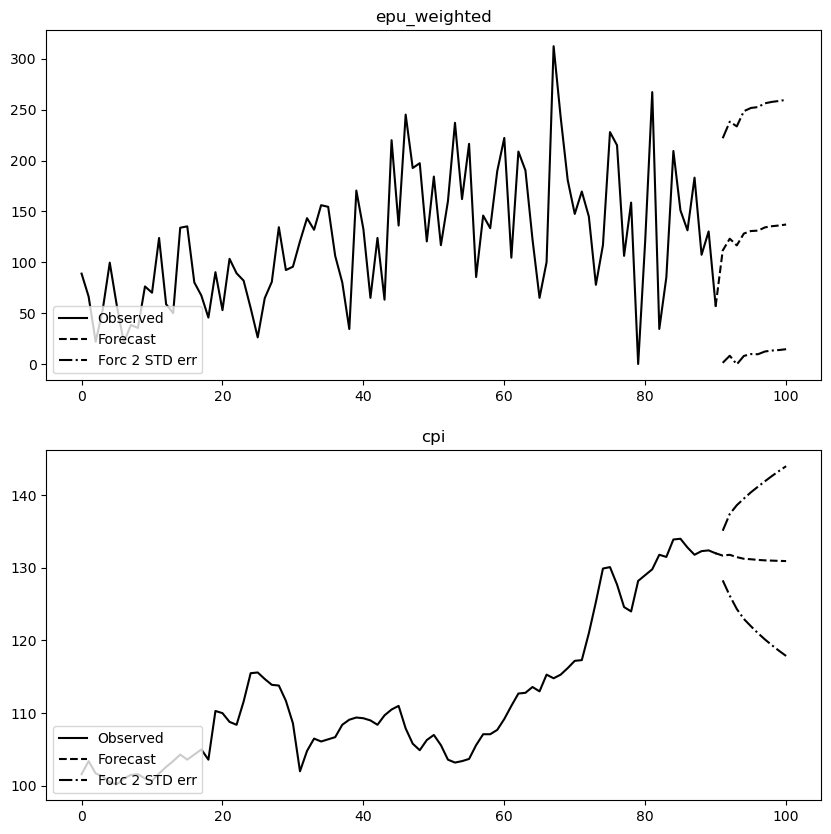

In [21]:
fitted_model.plot_forecast(steps=10)